### Mount google drive, download data and unzip data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samyarr","key":"1a7836e79d6709aea03097158434d3c9"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download samyarr/iranvehicleplatedataset

 98% 599M/612M [00:06<00:00, 110MB/s] 
100% 612M/612M [00:06<00:00, 94.2MB/s]


In [6]:
!mkdir dataset
!cp /content/iranvehicleplatedataset.zip dataset/

In [7]:
!unzip -q /content/dataset/iranvehicleplatedataset.zip -d /content/dataset  

### read images and bounding boxes

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET

np.random.seed(13)
tf.random.set_seed(13)

In [2]:
def read_content(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  list_with_all_boxes = []
  for boxes in root.iter('object'):
      filename = root.find('filename').text
      ymin, xmin, ymax, xmax = None, None, None, None
      # /224.0 to normalize it between 0 and 1
      ymin = int(boxes.find("bndbox/ymin").text)/224.0
      xmin = int(boxes.find("bndbox/xmin").text)/224.0
      ymax = int(boxes.find("bndbox/ymax").text)/224.0
      xmax = int(boxes.find("bndbox/xmax").text)/224.0
      list_with_single_boxes = [xmin, ymin, xmax, ymax]
      list_with_all_boxes.append(list_with_single_boxes)
  return filename, list_with_all_boxes

def get_all_boxes(path):
  img_names = []
  gts = []
  for p in sorted(os.listdir(path)):
    if p.endswith(".xml"):
      name, boxes = read_content(os.path.join(path,p))
      img_names.append(name)
      gts.append(boxes)
  img_names = np.array(img_names)
  gts = np.array(gts).squeeze()
  return img_names, gts

annot_path = "/content/dataset/Vehicle Plates annotations/Vehicle Plates annotations/"
img_names, gts = get_all_boxes(annot_path)

def get_all_images(path):
  imgs = []
  for p in sorted(os.listdir(path)):
    if p.endswith(".png"):
      # /255.0 to normalize image between 0 and 1
      im = cv2.imread(os.path.join(path,p), 1)
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255.0
      imgs.append(im)
  imgs = np.array(imgs)
  return imgs

img_path = "/content/dataset/Vehicle Plates/Vehicle Plates"
imgs = get_all_images(img_path)

img_size = 224
channel_num = 3
print("Images: ", imgs.shape)
print("Ground truth boxes: ", gts.shape)

Images:  (313, 224, 224, 3)
Ground truth boxes:  (313, 4)


### We have 313 RGB(3 channels) images which each of them is 224x224, we will split images to train, validation and test sets.

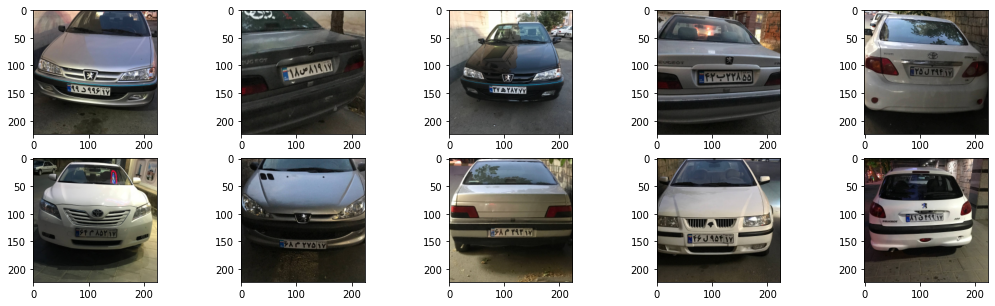

In [3]:
# some visualization of data
tmps = imgs[:10].copy()

fig = plt.figure(figsize=(18,5))
rows, columns, i = 2, 5, 1
for tmp in tmps:
  fig.add_subplot(rows, columns, i)
  tmp = cv2.normalize(tmp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  xmin, ymin, xmax, ymax = gts[i-1]
  i += 1
  tmp = cv2.rectangle(tmp, (int(xmin),int(ymin)),
                      (int(xmax),int(ymax)), (255,0,0),2)
  plt.imshow(tmp)
  

In [4]:
# shuffle images and ground trurth bounding boxes
shuffler = np.random.permutation(len(imgs))
imgs = imgs[shuffler]
gts = gts[shuffler]

In [5]:
train_imgs, val_imgs, test_imgs, _ = np.split(imgs,[253,283,313])
train_gts, val_gts, test_gts, _ = np.split(gts,[253,283,313])

print("train imgs:", train_imgs.shape, "validation imgs:", val_imgs.shape, "test imgs:", test_imgs.shape)
print("train gts:", train_gts.shape, "validation gts:", val_gts.shape, "test gts:", test_gts.shape)

train imgs: (253, 224, 224, 3) validation imgs: (30, 224, 224, 3) test imgs: (30, 224, 224, 3)
train gts: (253, 4) validation gts: (30, 4) test gts: (30, 4)


### Training

In [6]:
def create_model(model_name, input_shape):
  K.clear_session()
  print("---------------------------------------------------------------------")
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

  if model_name == "Xception":
    model.add(tf.keras.applications.Xception(include_top=False, input_shape=input_shape))
  elif model_name == "VGG16":
    model.add(tf.keras.applications.VGG16(include_top=False, input_shape=input_shape))
  elif model_name == "ResNet50":
    model.add(tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape))
  elif model_name == "ResNet101":
    model.add(tf.keras.applications.ResNet101(include_top=False, input_shape=input_shape))
  elif model_name == "ResNet152":
    model.add(tf.keras.applications.ResNet152(include_top=False, input_shape=input_shape))
  elif model_name == "InceptionV3":
    model.add(tf.keras.applications.InceptionV3(include_top=False, input_shape=input_shape))
  elif model_name == "DenseNet121":
    model.add(tf.keras.applications.DenseNet121(include_top=False, input_shape=input_shape))
  elif model_name == "DenseNet169":
    model.add(tf.keras.applications.DenseNet169(include_top=False, input_shape=input_shape))
  elif model_name == "DenseNet201":
    model.add(tf.keras.applications.DenseNet201(include_top=False, input_shape=input_shape))
  elif model_name == "EfficientNetB0":
    model.add(tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape))

  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.add(tf.keras.layers.Dense(64,activation='relu'))
  model.add(tf.keras.layers.Dense(32,activation='relu'))
  model.add(tf.keras.layers.Dense(16,activation='relu'))
  model.add(tf.keras.layers.Dense(8,activation='relu'))
  model.add(tf.keras.layers.Dense(4, activation='relu'))

  model.layers[-7].trainable = False

  model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.mean_squared_error,
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
  
  print("Model with backbone {} has {} parameters in total".format(model_name, model.count_params()))
  return model

In [7]:
def compute_iou(preds, gts):
    ious = []
    for boxA, boxB in zip(preds, gts):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        # compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
        ious.append(iou)
    return np.mean(ious), ious

In [8]:
initial_learning_rate = 0.0001
img_size = 224
input_shape = (img_size, img_size, 3)

def lr_step_decay(epoch, lr):
  drop_rate = 0.2
  epochs_drop = 3.0
  return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

scheduler = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

model_names = ["Xception", "VGG16", "ResNet50", "ResNet101", "ResNet152",
               "InceptionV3", "DenseNet121", "DenseNet169",
               "DenseNet201", "EfficientNetB0"]

predictions = []
histories = []
ious = []
for model_name in model_names:
  model = create_model(model_name, input_shape)
  history = model.fit(train_imgs, train_gts, batch_size=8, epochs=8,
                      validation_data=(val_imgs,val_gts))
  prediction = model.predict(test_imgs)
  iou = compute_iou(prediction, gts)[0]
  print("IoU for {} is {}".format(model_name,iou))
  ious.append(iou)
  histories.append(history)
  predictions.append(prediction)

---------------------------------------------------------------------
Model with backbone Xception has 20995396 parameters in total
Epoch 1/8
32/32 [==============================] - 10s 167ms/step - loss: 0.0519 - mean_absolute_error: 0.1826 - val_loss: 0.0278 - val_mean_absolute_error: 0.1399
Epoch 2/8
32/32 [==============================] - 3s 92ms/step - loss: 0.0173 - mean_absolute_error: 0.1057 - val_loss: 0.0110 - val_mean_absolute_error: 0.0860
Epoch 3/8
32/32 [==============================] - 3s 92ms/step - loss: 0.0083 - mean_absolute_error: 0.0716 - val_loss: 0.0089 - val_mean_absolute_error: 0.0749
Epoch 4/8
32/32 [==============================] - 3s 92ms/step - loss: 0.0063 - mean_absolute_error: 0.0616 - val_loss: 0.0059 - val_mean_absolute_error: 0.0631
Epoch 5/8
32/32 [==============================] - 3s 93ms/step - loss: 0.0048 - mean_absolute_error: 0.0537 - val_loss: 0.0058 - val_mean_absolute_error: 0.0625
Epoch 6/8
32/32 [==============================] - 3s 93

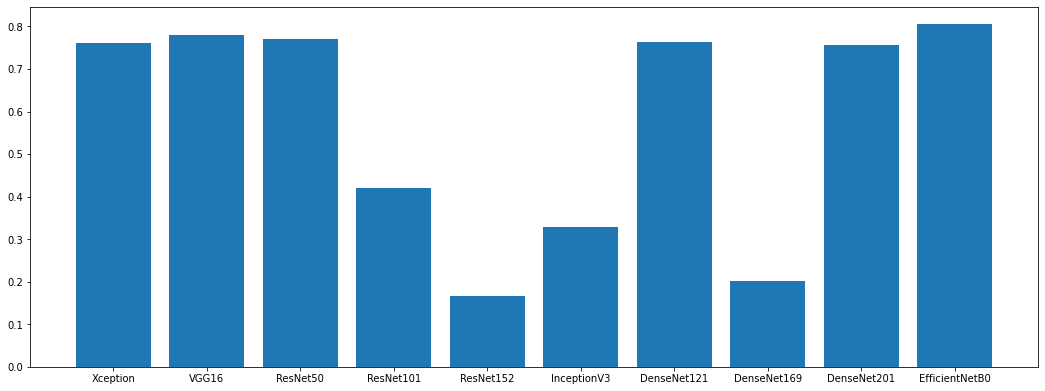

In [9]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(model_names,ious)
plt.show()

--------------------------------------------------------------------------------------
Xception predictions : 


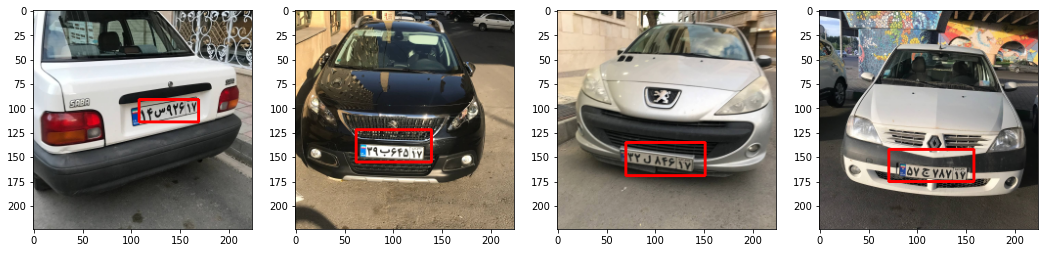

--------------------------------------------------------------------------------------
VGG16 predictions : 


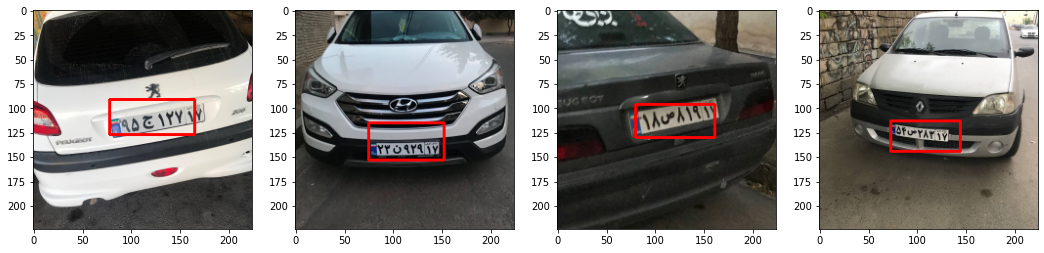

--------------------------------------------------------------------------------------
ResNet50 predictions : 


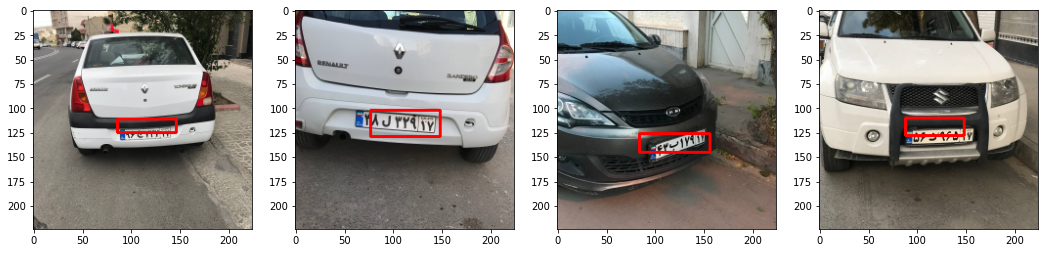

--------------------------------------------------------------------------------------
ResNet101 predictions : 


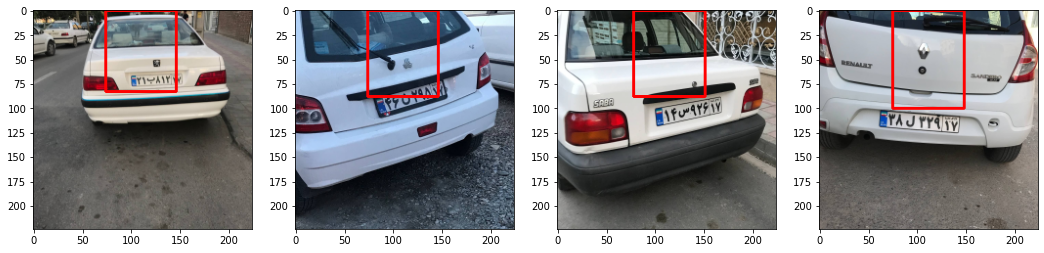

--------------------------------------------------------------------------------------
ResNet152 predictions : 


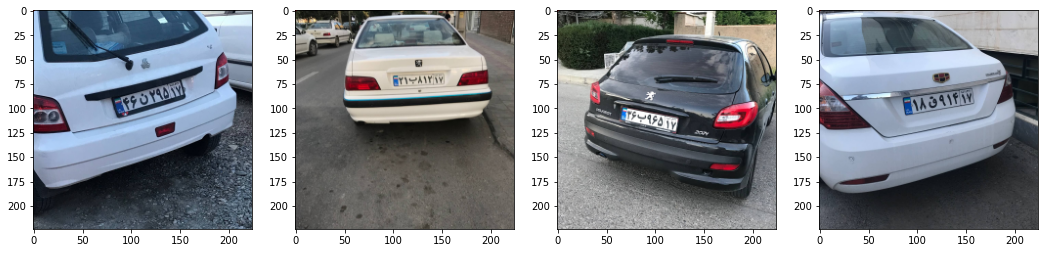

--------------------------------------------------------------------------------------
InceptionV3 predictions : 


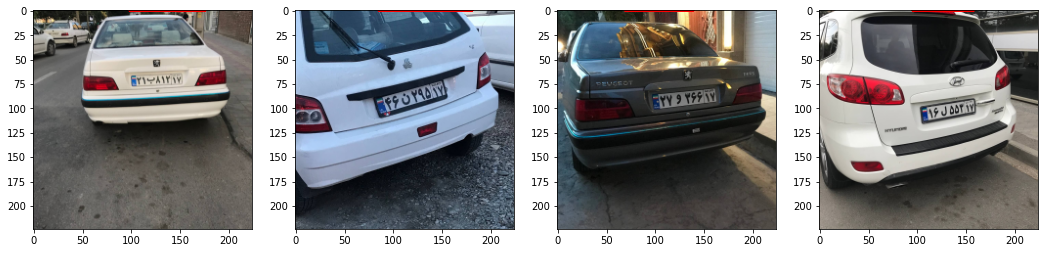

--------------------------------------------------------------------------------------
DenseNet121 predictions : 


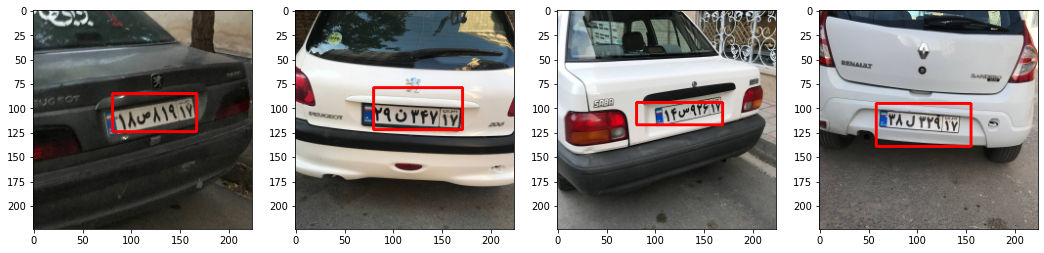

--------------------------------------------------------------------------------------
DenseNet169 predictions : 


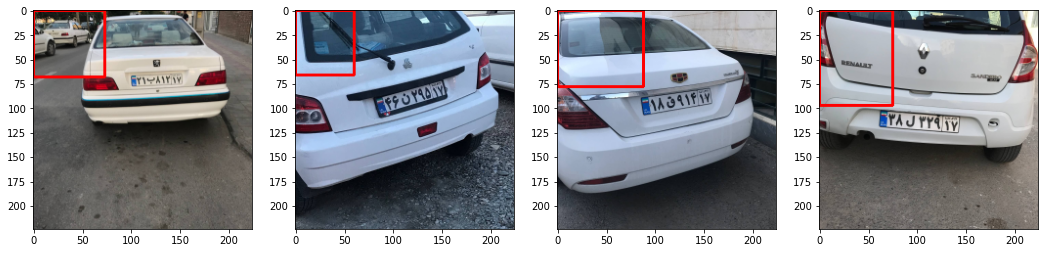

--------------------------------------------------------------------------------------
DenseNet201 predictions : 


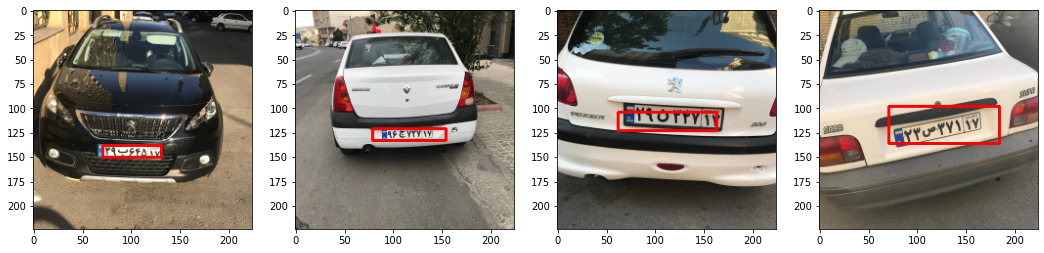

--------------------------------------------------------------------------------------
EfficientNetB0 predictions : 


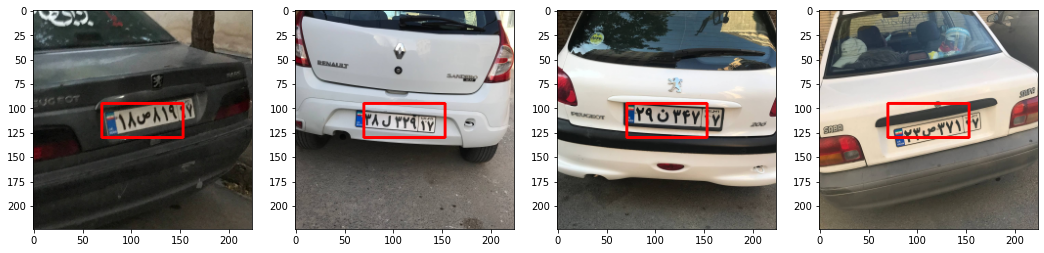

In [10]:
rows, columns = 1, 4
for index,model_predictions in enumerate(predictions):
  fig = plt.figure(figsize=(18,10))
  ious = compute_iou(model_predictions, test_gts)[1]
  zipped = zip(model_predictions, ious, list(range(len(model_predictions))))
  zipped = sorted(zipped, key=lambda x:x[1], reverse=True)
  print("--------------------------------------------------------------------------------------")
  print("{} predictions : ".format(model_names[index]))
  j = 1
  for zip in zipped[:columns]:
    i = zip[2]
    tmp = test_imgs[i]
    tmp = cv2.normalize(tmp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    tmp = cv2.rectangle(tmp, (int(zip[0][0]*img_size),int(zip[0][1]*img_size)),
                      (int(zip[0][2]*img_size),int(zip[0][3]*img_size)), (255,0,0), 2)

    fig.add_subplot(rows, columns, j)
    j += 1
    plt.imshow(tmp)
  del zip
  plt.show()